# Model Behavior
Apply logistic regression. Predict memory recall given alpha, gamma, and exponent changes on a single trial basis.

## Set-up

### Imports

In [98]:
# Imports - standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp, zscore
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import accuracy_score


In [3]:
# Imports - custom
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from info import PATIENTS
from settings import COLORS

### Settings

### Functions

In [207]:
# Ordinal logistic regression helper func

def run_ordered_logit(results, features_x, feature_y):
    """
    Run ordered logistic regression to predict behavior (confidence rating)
    from spectral parameters, for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.    

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x]
    y = results[feature_y]

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    for feature in features_x:
        X[feature] = zscore(X[feature])

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # run ordered logistic regression
    model = OrderedModel(y_train, X_train, distr='logit')
    results = model.fit(method='bfgs')

    # predict
    pred_probs = results.predict(X_test)
    pred_categories = np.argmax(pred_probs.values, axis=1) + 1
    score = accuracy_score(y_test, pred_categories)

    return model, results, score



In [288]:
# Binary Logistic regression helper func

def run_logistic_regression(results, features_x, feature_y):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.    

    Returns
    -------
    model : statsmodels Logit object
        Logistic regression model.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x]
    y = results[feature_y]

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # z-score each feature
    for feature in features_x:
        X[feature] = zscore(X[feature])

    # run logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = sm.Logit(y_train, X_train).fit()
    y_pred_prob = model.predict(X_test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    score = accuracy_score(y_test, y_pred).astype(float)

    return model, score
    

In [306]:
# Binary Logistic regression with cross-validation helper func

def run_logistic_regression_cv(results, features_x, feature_y):
    """
    Run logistic regression to predict behavior from spectral parameters,
    for a given subject/channel/material, using cross-validation.

    Parameters
    ----------
    results : pandas DataFrame
        Dataframe containing spectral parameters and behavior for each subject.
    features_x : list of str
        Feature names to use for prediction.
    feature_y : str
        Target feature to predict.  

    Returns
    -------
    clf : sklearn LogisticRegression object
        Logistic regression classifier.
    score : float
        Accuracy score for the classifier.
    """

    # get data
    X = results[features_x].to_numpy()
    y = results[feature_y].to_numpy()

    # remove nans
    nan_idx = np.isnan(X).any(axis=1) | np.isnan(y)
    X = X[~nan_idx]
    y = y[~nan_idx]

    # z-score each feature
    X = zscore(X, axis=0)

    # run logistic regression with cross-validation
    clf = LogisticRegression(random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    score = scores.mean()

    return clf, score



In [32]:
# plotting functions

def plot_score(df, chance=0.5):
    # plot scores by material
    _, ax = plt.subplots(figsize=[6,4])
    bin_edges = np.arange(0, 1.1, 0.1)
    ax.hist(df.loc[df['material']=='words', 'score'], bin_edges, alpha=0.5, label='word-encoding')
    ax.hist(df.loc[df['material']=='faces', 'score'], bin_edges, alpha=0.5, label='face-encoding')
    # ax.axvline(0.5, color='k', linestyle='--')
    ax.axvline(chance, color='k', linestyle='--')
    ax.set(xlabel='score', ylabel='count')
    ax.set_title("logistic regression scores")
    ax.legend()
    plt.show()

    # plot scores by patient and material
    _, ax = plt.subplots(1, 2, figsize=[12, 4])
    for ax, material in zip(ax, ['words', 'faces']):
        for i_patient, patient in enumerate(PATIENTS):
            ax.hist(df.loc[(df['patient']==patient) & (df['material']==material), 'score'], bin_edges, alpha=0.5, color=f'C{i_patient}')
            ax.axvline(df.loc[(df['patient']==patient) & (df['material']==material), 'score'].mean(), color=f'C{i_patient}', linestyle='--')
        ax.set(xlabel='score', ylabel='count', title=material)
        ax.axvline(chance, color='k', linestyle='--')
    plt.show()

    # print mean scores
    print(f"mean score:\t\t {df['score'].mean():0.3f}")
    print(f"\nmean word score:\t {df.loc[df['material']=='words', 'score'].mean():0.3f}")
    print(f"median word score:\t {df.loc[df['material']=='words', 'score'].median():0.3f}")
    print(f"\nmean face score:\t {df.loc[df['material']=='faces', 'score'].mean():0.3f}")
    print(f"median face score:\t {df.loc[df['material']=='faces', 'score'].median():0.3f}")


## Main

### load data
* load single-trial spectral parameterization results
* load behavioral metadata
* merge

In [223]:
# load single trial spectral parameter results (pipeline step 7)
results = pd.read_csv(f"{PROJECT_PATH}/data/results/single_trial_params.csv", index_col=0)
results

patient material  trial  channel  behavior  exp_diff  alpha_diff  \
0    pat02     word      0        0       1.0  0.284569   -3.134129   
0    pat02     word      0        1       1.0 -0.267297    2.199037   
0    pat02     word      0        2       1.0  0.347018   -3.045161   
0    pat02     word      0        3       1.0  0.704846    0.111784   
0    pat02     word      0        4       1.0 -0.099727   -2.979044   
..     ...      ...    ...      ...       ...       ...         ...   
0    pat22     face     99       48       0.0       NaN         NaN   
0    pat22     face     99       49       0.0       NaN         NaN   
0    pat22     face     99       50       0.0       NaN         NaN   
0    pat22     face     99       51       0.0       NaN         NaN   
0    pat22     face     99       52       0.0       NaN         NaN   

    gamma_diff  
0     2.645092  
0     4.942024  
0    -1.026259  
0   -12.517384  
0    -3.883535  
..         ...  
0          NaN  
0          NaN  
0          NaN  
0          NaN  
0          NaN  

[137902 rows x 8 columns]

In [224]:
from paths import DATASET_PATH
sys.path.append("../scripts/pipeline")
from step1_convert_matlab_to_python import import_epochs

metadata = []

dir_input = f"{DATASET_PATH}/iEEG"
for patient in PATIENTS:
    for material in ['words', 'faces']:
        fname = f"{patient}_{material}.mat"
        
        # display progress
        print('\n__________Reformatting: %s ____________________\n' %fname)
    
        # import epoch data
        epochs = import_epochs(f"{dir_input}/{fname}")

        metadata_i = epochs.metadata.reset_index()
        metadata_i.rename(columns={'index' : 'trial'}, inplace=True)
        f_parts = fname.split('_')
        metadata_i['patient'] = patient
        metadata_i['material'] = material
        metadata.append(metadata_i)
metadata = pd.concat(metadata).reset_index(drop=True)
metadata


__________Reformatting: pat02_words.mat ____________________

Adding metadata with 5 columns
99 matching events found
No baseline correction applied
0 bad epochs dropped

__________Reformatting: pat02_faces.mat ____________________

Adding metadata with 5 columns
99 matching events found
No baseline correction applied
0 bad epochs dropped

__________Reformatting: pat04_words.mat ____________________

Adding metadata with 5 columns
99 matching events found
No baseline correction applied
0 bad epochs dropped

__________Reformatting: pat04_faces.mat ____________________

Adding metadata with 5 columns
99 matching events found
No baseline correction applied
0 bad epochs dropped

__________Reformatting: pat05_words.mat ____________________

Adding metadata with 5 columns
97 matching events found
No baseline correction applied
0 bad epochs dropped

__________Reformatting: pat05_faces.mat ____________________

Adding metadata with 5 columns
97 matching events found
No baseline correction app

trial  trial_num  pleasantness  confidence  recalled  reaction_time  \
0         0        2.0           2.0         4.0       1.0         2287.5   
1         1        3.0           5.0         1.0       1.0         2024.6   
2         2        4.0           3.0         1.0       1.0         2318.8   
3         3        5.0           1.0         1.0       1.0         2036.4   
4         4        6.0           2.0         2.0       1.0         2293.0   
...     ...        ...           ...         ...       ...            ...   
2578     95       98.0           4.0         4.0       1.0         5394.7   
2579     96       99.0           3.0         4.0       1.0         4244.4   
2580     97      100.0           5.0         6.0       0.0         4177.4   
2581     98      101.0           3.0         1.0       1.0         4663.1   
2582     99      102.0           5.0         6.0       0.0         3723.5   

     patient material  
0      pat02    words  
1      pat02    words  
2      pat02    words  
3      pat02    words  
4      pat02    words  
...      ...      ...  
2578   pat22    faces  
2579   pat22    faces  
2580   pat22    faces  
2581   pat22    faces  
2582   pat22    faces  

[2583 rows x 8 columns]

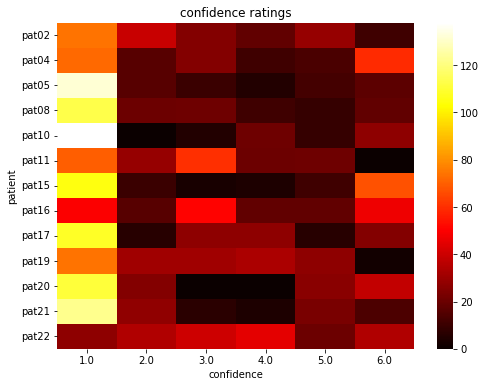

In [221]:
# count the number of times each 'patient' had each 'confidence' rating
confidence_counts = metadata.groupby(['patient', 'confidence']).size().unstack()
confidence_counts = confidence_counts.fillna(0)
confidence_counts = confidence_counts.astype(int).reset_index()
# confidence_counts = confidence_counts.div(confidence_counts.sum(axis=1), axis=0) * 100 # change to percentage

# plot the number of times each 'patient' had each 'confidence' rating
_, ax = plt.subplots(figsize=[8,6])
sns.heatmap(confidence_counts.set_index('patient'), cmap='hot', ax=ax)
ax.set_title("confidence ratings")
plt.show()



In [225]:
# merge results and metadata
results['material'] = results['material'] + 's'
results = results.merge(metadata, on=['patient', 'material', 'trial'])
results

patient material  trial  channel  behavior  exp_diff  alpha_diff  \
0        pat02    words      0        0       1.0  0.284569   -3.134129   
1        pat02    words      0        1       1.0 -0.267297    2.199037   
2        pat02    words      0        2       1.0  0.347018   -3.045161   
3        pat02    words      0        3       1.0  0.704846    0.111784   
4        pat02    words      0        4       1.0 -0.099727   -2.979044   
...        ...      ...    ...      ...       ...       ...         ...   
137897   pat22    faces     99       48       0.0       NaN         NaN   
137898   pat22    faces     99       49       0.0       NaN         NaN   
137899   pat22    faces     99       50       0.0       NaN         NaN   
137900   pat22    faces     99       51       0.0       NaN         NaN   
137901   pat22    faces     99       52       0.0       NaN         NaN   

        gamma_diff  trial_num  pleasantness  confidence  recalled  \
0         2.645092        2.0           2.0         4.0       1.0   
1         4.942024        2.0           2.0         4.0       1.0   
2        -1.026259        2.0           2.0         4.0       1.0   
3       -12.517384        2.0           2.0         4.0       1.0   
4        -3.883535        2.0           2.0         4.0       1.0   
...            ...        ...           ...         ...       ...   
137897         NaN      102.0           5.0         6.0       0.0   
137898         NaN      102.0           5.0         6.0       0.0   
137899         NaN      102.0           5.0         6.0       0.0   
137900         NaN      102.0           5.0         6.0       0.0   
137901         NaN      102.0           5.0         6.0       0.0   

        reaction_time  
0              2287.5  
1              2287.5  
2              2287.5  
3              2287.5  
4              2287.5  
...               ...  
137897         3723.5  
137898         3723.5  
137899         3723.5  
137900         3723.5  
137901         3723.5  

[137902 rows x 13 columns]

### Run regression
Regress behavior on spectral features
* Ordered/ordinal logistic regression (1-6 confidence rating)
* Binary logistic regression (binary remembered/forgotten)
* Binary logistic regression with cross-validation

#### Ordered logistic regression
regress behavior (confidence rating, 1-6) on spectral parameters 

In [206]:
# # run ordered logistic regression for all channels in each trial condition

# features_x = ['exp_diff', 'alpha_diff', 'gamma_diff']

# # create dataframe to store results (one row for each channel-material pair)
# df = pd.DataFrame(columns=['patient', 'material', 'channel', 'exp_coef', 
#                            'alpha_coef', 'gamma_coef', 'exp_pval',
#                             'alpha_pval', 'gamma_pval', 'score'])

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     print(f"patient {patient}")
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data 
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 model, res, score = run_ordered_logit(res_i, features_x, 'confidence')
#                 df_i = pd.DataFrame({'patient' : patient,
#                                     'material' : material,
#                                     'channel' : channel,
#                                     'exp_coef' : res.params[0],
#                                     'alpha_coef' : res.params[1],
#                                     'gamma_coef' : res.params[2],
#                                     'exp_pval' : res.pvalues[0],
#                                     'alpha_pval' : res.pvalues[1],
#                                     'gamma_pval' : res.pvalues[2],
#                                     'score' : score},
#                                     index=[0])
#                 df = pd.concat([df, df_i], axis=0)
#             except:
#                 pass

# df

In [214]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)
df

patient material  channel  exp_coef  alpha_coef  gamma_coef  exp_pval  \
0    pat02    words        0  0.050752   -0.074132    0.534672  0.837750   
0    pat02    faces        0 -0.071749   -0.065502    0.112466  0.767859   
0    pat02    words        1  0.081823   -0.030260   -0.088118  0.707543   
0    pat02    faces        1 -0.108099   -0.006772   -0.155312  0.636531   
0    pat02    words        2 -0.147973    0.263788   -0.314793  0.496558   
..     ...      ...      ...       ...         ...         ...       ...   
0    pat22    faces       50 -0.026995   -0.317926    0.226007  0.910590   
0    pat22    words       51  0.169266   -0.246048    0.007386  0.408230   
0    pat22    faces       51 -0.004801   -0.363537   -0.004340  0.983801   
0    pat22    words       52 -0.396535    0.367376   -0.306553  0.167012   
0    pat22    faces       52 -0.238231    0.113310   -0.433260  0.356107   

    alpha_pval  gamma_pval     score  
0     0.766909    0.047462  0.500000  
0     0.775485    0.682186  0.375000  
0     0.901057    0.729153  0.411765  
0     0.978103    0.545617  0.117647  
0     0.248598    0.186945  0.578947  
..         ...         ...       ...  
0     0.190147    0.333982  0.222222  
0     0.232860    0.971141  0.200000  
0     0.154586    0.983570  0.111111  
0     0.134433    0.234841  0.350000  
0     0.628283    0.094689  0.166667  

[1336 rows x 10 columns]

#### Logistic regression (binary)
regress behavior (binarized memory performance) on spectral parameters

In [295]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exp_diff', 'alpha_diff', 'gamma_diff']

# # create dataframe to store results (one row for each channel-material pair)
# df = pd.DataFrame(columns=['patient', 'material', 'channel', 'exp_coef', 
#                            'alpha_coef', 'gamma_coef', 'score'])

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data 
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 model, score = run_logistic_regression(res_i, features_x, 'behavior')
#                 df_i = pd.DataFrame({'patient' : patient,
#                                     'material' : material,
#                                     'channel' : channel,
#                                     'exp_coef' : model.params[1],
#                                     'alpha_coef' : model.params[2],
#                                     'gamma_coef' : model.params[3],
#                                     'exp_pval' : model.pvalues[1],
#                                     'alpha_pval' : model.pvalues[2],
#                                     'gamma_pval' : model.pvalues[3],
#                                     'score' : score},
#                                     index=[0])
#                 df = pd.concat([df, df_i], axis=0)
#             except:
#                 pass

# df

In [300]:
# save/load results from above
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
df

patient material  channel  exp_coef  alpha_coef  gamma_coef     score  \
0    pat02    words        0 -0.080452    0.170743   -0.309807  0.812500   
0    pat02    faces        0  0.452703    0.519698    0.419791  0.500000   
0    pat02    words        1 -0.151464    0.054004   -0.012882  0.764706   
0    pat02    faces        1 -0.422668    0.015120   -0.345081  0.470588   
0    pat02    words        2  0.082581   -0.408622   -0.017508  0.800000   
..     ...      ...      ...       ...         ...         ...       ...   
0    pat22    faces       50 -0.386204   -0.842756    0.204284  0.500000   
0    pat22    words       51  0.758345    0.290652   -0.353621  0.600000   
0    pat22    faces       51  0.089265    0.140658   -0.260263  0.611111   
0    pat22    words       52 -0.106123    0.125869    0.284068  0.450000   
0    pat22    faces       52 -0.135489    0.450925   -0.252494  0.555556   

    exp_pval  alpha_pval  gamma_pval  
0   0.818751    0.599975    0.317499  
0   0.155389    0.102149    0.175965  
0   0.635776    0.875122    0.967810  
0   0.141207    0.956747    0.215818  
0   0.819740    0.225362    0.953059  
..       ...         ...         ...  
0   0.177754    0.015472    0.466878  
0   0.010149    0.373008    0.188426  
0   0.745615    0.590574    0.340521  
0   0.750575    0.656794    0.336601  
0   0.633844    0.119355    0.396969  

[1335 rows x 10 columns]

#### Logistic regression (binary) with cross-validation
regress behavior (binarized memory performance) on spectral parameters

In [334]:
# # run logistic regression for all channels in each trial condition

# features_x = ['exp_diff', 'alpha_diff', 'gamma_diff']

# # create dataframe to store results (one row for each channel-material pair)
# df = results.groupby(['patient', 'channel', 'material']).mean().reset_index()
# df = df[['patient', 'channel', 'material']]
# df['score'] = np.nan 

# # run logistic regression 
# for i_patient, patient in enumerate(PATIENTS):
#     channels = results.loc[results['patient']==patient, 'channel'].unique()
#     for channel in channels:
#         for i_material, material in enumerate(['words', 'faces']):
#             try: # some patients/channels don't have data
#                 res_i = results.loc[(results['patient']==patient) & \
#                                     (results['channel']==channel) & \
#                                     (results['material']==material)]
#                 clf, score = run_logistic_regression_cv(res_i, features_x, 'behavior')
#                 df_index = (df['patient']==patient) & (df['channel']==channel) & (df['material']==material)
#                 df.loc[df_index, 'score'] = score
#             except:
#                 pass

# df

In [305]:
# save/load results
# df.to_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv")
df = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
df

patient  channel material     score
0      pat02        0     face  0.611667
1      pat02        0     word  0.787500
2      pat02        1     face  0.588971
3      pat02        1     word  0.793382
4      pat02        2     face  0.628070
...      ...      ...      ...       ...
1385   pat22       50     word  0.524211
1386   pat22       51     face  0.570588
1387   pat22       51     word  0.591579
1388   pat22       52     face  0.605229
1389   pat22       52     word  0.560526

[1390 rows x 4 columns]

### Plot regression results

In [301]:
# set chance level (0.5 for binary classification, 1/6 for 6-class classification)
chance = 0.5

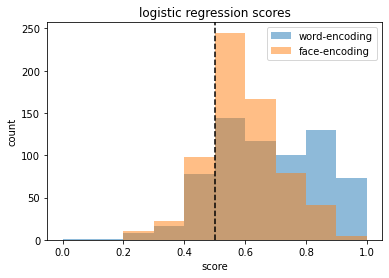

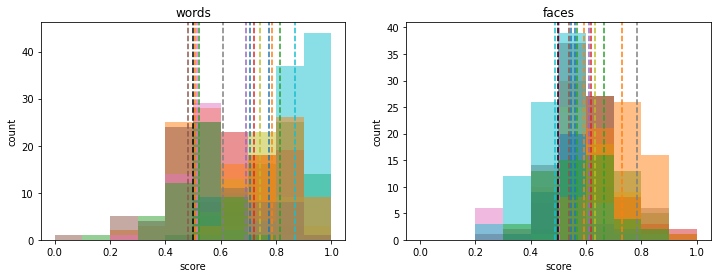

mean score:		 0.634

mean word score:	 0.676
median word score:	 0.700

mean face score:	 0.592
median face score:	 0.600


In [302]:
# plot score and print average scores
plot_score(df, chance=chance)

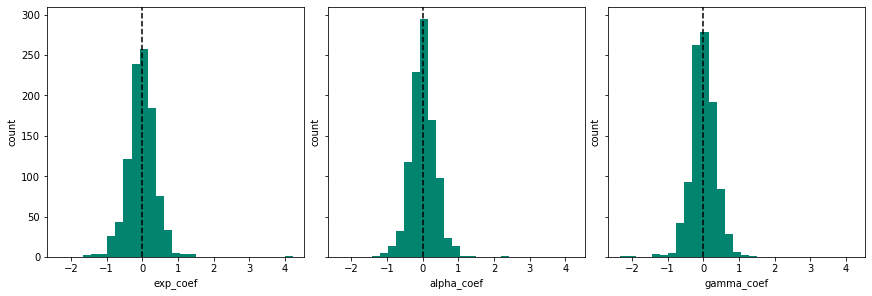

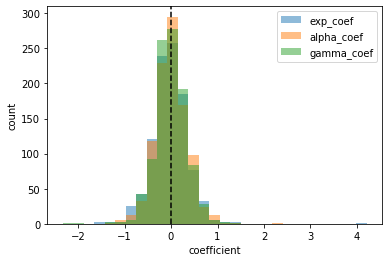

In [303]:
# plot histogram of coefficients

# get those with scores above chance
df_plt = df.loc[df['score']>(0.5)]
# df_plt = df.copy()

# plot
all_values = df_plt[['exp_coef', 'alpha_coef', 'gamma_coef']].values.flatten()
bins = np.linspace(np.min(all_values), np.max(all_values), 30)
_, ax = plt.subplots(1, 3, figsize=[12, 4], sharey=True, constrained_layout=True)
for i, feature in enumerate(['exp_coef', 'alpha_coef', 'gamma_coef']):
    ax[i].hist(df_plt[feature], bins, color=COLORS['blue'])
    ax[i].set(xlabel=feature, ylabel='count')
    ax[i].axvline(0, color='k', linestyle='--') 
plt.show()


# plot
all_values = df_plt[['exp_coef', 'alpha_coef', 'gamma_coef']].values.flatten()
bins = np.linspace(np.min(all_values), np.max(all_values), 30)
_, ax = plt.subplots(figsize=[6, 4])
for i, feature in enumerate(['exp_coef', 'alpha_coef', 'gamma_coef']):
    ax.hist(df_plt[feature], bins, alpha=0.5, label=feature)
ax.axvline(0, color='k', linestyle='--')
ax.set(xlabel='coefficient', ylabel='count')
ax.legend()
plt.show()


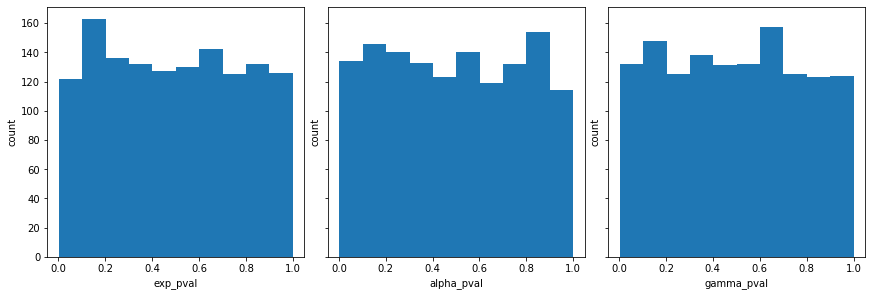

In [304]:
# plot histogram of pvalues

# get those with scores above chance
# df_plt = df.loc[df['score']>(1/6)]
df_plt = df.copy()

# plot
_, ax = plt.subplots(1, 3, figsize=[12, 4], sharey=True, constrained_layout=True)
for i, feature in enumerate(['exp_pval', 'alpha_pval', 'gamma_pval']):
    ax[i].hist(df_plt[feature])
    ax[i].set(xlabel=feature, ylabel='count')
plt.show()


### Analyze coefficients and p-values
Run stats and create figures for manuscript

In [258]:
# run 1-smaple t-test to determine if coefficients are significantly different from 0

# print coefficients
print(f"Mean coefficients:")
print(f"exp:\t {df['exp_coef'].mean():0.5f}")
print(f"alpha:\t {df['alpha_coef'].mean():0.5f}")
print(f"gamma:\t {df['gamma_coef'].mean():0.5f}")

# run 1 sample t-test
print("\n\nT-test results:")
for ii in range(3):
    data_i = df.iloc[:,ii+3].to_numpy()
    t, p = ttest_1samp(data_i, 0)
    print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")
    
# run 1 sample t-test for word-/face-encoding only
for material in ['words', 'faces']:
    print(f"\n\nT-test, {material}-encoding:")
    df_m = df.loc[df['material']==material] # subset dataframe
    for ii in range(3):
        data_i = df_m.iloc[:,ii+3]
        t, p = ttest_1samp(data_i, 0)
        print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.3f}, p={p:0.3f}")

Mean coefficients:
exp:	 -0.01423
alpha:	 0.01724
gamma:	 0.00786


T-test results:
exp:	 t=-1.361, p=0.174
alpha:	 t=1.803, p=0.072
gamma:	 t=0.872, p=0.383


T-test, words-encoding:
exp:	 t=-2.391, p=0.017
alpha:	 t=1.202, p=0.230
gamma:	 t=-0.186, p=0.852


T-test, faces-encoding:
exp:	 t=0.708, p=0.479
alpha:	 t=1.357, p=0.175
gamma:	 t=1.498, p=0.135


In [260]:
# analyze coefficients for predictive channels only

def analyze_coef(df):
    """
    Evaluate whether logistic regression coefficients are significantly different
    than zero. Print results of 1-sample t-test.
    """

    for material in ['words', 'faces']:
        print(f"\nT-test, {material}-encoding:")
        for ii in range(3):
            df_m = df.loc[df['material']==material]
            data_i = df_m.iloc[:,ii+3]
            t, p = ttest_1samp(data_i, 0)
            print(f"{df.columns[ii+3].split('_')[0]}:\t t={t:0.5f}, p={p:0.5f}")

# test 
for threshold in np.linspace(0.1,0.9,9):
    print(f"\n\nThreshold = {threshold} ********************")
    df_i = df.loc[df['score'] > threshold]
    analyze_coef(df_i)

In [261]:
# count number of signifcant coefficients for each feature
alpha = 0.05
for feature in ['exp', 'alpha', 'gamma']:
    n_sig = np.sum(df[f'{feature}_pval']<alpha)
    print(f"{feature}:\t{n_sig} ({n_sig/len(df)*100:0.2f}%)")


exp:	59 (4.42%)
alpha:	53 (3.97%)
gamma:	51 (3.82%)


These results suggest that modulation of the aperiodic exponent on a single-trial basis is predictive of memory recall for word-encoding trials but not for face-eencoding trials. 

In [292]:
df['score'] = df['score'].astype(float)


T-test, words-encoding:
t=36.745, p=1.94e-162

T-test, faces-encoding:
t=29.934, p=2.13e-125


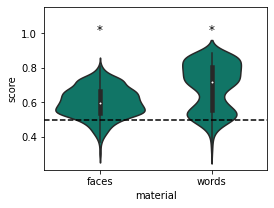

In [318]:
# plot violin plot of regression scores

# set plotting params
plotting_params = {
    'data'  :   df,
    'x'     :   'material',
    'y'     :   'score',
}

# plot
_, ax = plt.subplots(figsize=[4,3])
sns.violinplot(**plotting_params, ax=ax, color=COLORS['blue'])
ax.axhline(chance, color='k', linestyle='--')

# add significance markers
for i_material, material in enumerate(['words', 'faces']):
    data = df.loc[df['material']==material, 'score']
    data = data[~np.isnan(data)]
    t, p = ttest_1samp(data, chance)
    if p < 0.05:
        ax.text(i_material, np.max(df['score'])*1.15, '*', fontsize=12, ha='center', va='center')

    # print stats
    print(f"\nT-test, {material}-encoding:")
    print(f"t={t:0.3f}, p={p:0.3n}")

ax.set_ylim([np.min(df['score'])-np.min(df['score'])*0.3, np.max(df['score'])*1.3])
plt.show()

#### plot score v. electrode coordinate

In [323]:
# load regression results from above
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores.csv", index_col=0)
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)

# merge channel info with regression results
df = pd.merge(results, df_elec, on=['patient', 'channel'])
df

patient material  channel  exp_coef  alpha_coef  gamma_coef     score  \
0      pat02    words        0 -0.080452    0.170743   -0.309807  0.812500   
1      pat02    faces        0  0.452703    0.519698    0.419791  0.500000   
2      pat02    words        1 -0.151464    0.054004   -0.012882  0.764706   
3      pat02    faces        1 -0.422668    0.015120   -0.345081  0.470588   
4      pat02    words        2  0.082581   -0.408622   -0.017508  0.800000   
...      ...      ...      ...       ...         ...         ...       ...   
1330   pat22    faces       50 -0.386204   -0.842756    0.204284  0.500000   
1331   pat22    words       51  0.758345    0.290652   -0.353621  0.600000   
1332   pat22    faces       51  0.089265    0.140658   -0.260263  0.611111   
1333   pat22    words       52 -0.106123    0.125869    0.284068  0.450000   
1334   pat22    faces       52 -0.135489    0.450925   -0.252494  0.555556   

      exp_pval  alpha_pval  gamma_pval          label     pos_y     pos_x  \
0     0.818751    0.599975    0.317499        A01-A02 -65.43100  61.94490   
1     0.155389    0.102149    0.175965        A01-A02 -65.43100  61.94490   
2     0.635776    0.875122    0.967810        A02-A03 -70.93895  57.17765   
3     0.141207    0.956747    0.215818        A02-A03 -70.93895  57.17765   
4     0.819740    0.225362    0.953059        A03-A04 -75.39550  51.39440   
...        ...         ...         ...            ...       ...       ...   
1330  0.177754    0.015472    0.466878  MOF_07-MOF_08  44.50000 -14.00000   
1331  0.010149    0.373008    0.188426  MOF_08-MOF_09  48.00000 -14.00000   
1332  0.745615    0.590574    0.340521  MOF_08-MOF_09  48.00000 -14.00000   
1333  0.750575    0.656794    0.336601  MOF_09-MOF_10  52.00000 -14.00000   
1334  0.633844    0.119355    0.396969  MOF_09-MOF_10  52.00000 -14.00000   

         pos_z  
0      3.55955  
1      3.55955  
2     12.15540  
3     12.15540  
4     20.94335  
...        ...  
1330  16.50000  
1331  23.50000  
1332  23.50000  
1333  30.00000  
1334  30.00000  

[1335 rows x 14 columns]

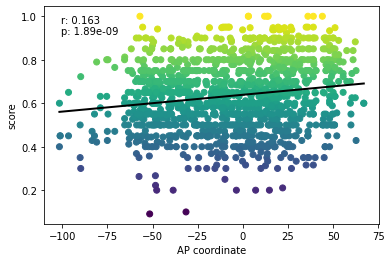

In [324]:
# compute correlation between score and position

# drop NaN
df_c = df.dropna()
x_data = df_c['pos_y']
y_data = df_c['score']

# plot data
fig, ax = plt.subplots(figsize=[6,4])
ax.scatter(x_data, y_data, c=y_data, cmap='viridis')
ax.set(xlabel=f"AP coordinate", ylabel="score")

# run regression and plot results
stats = linregress(x_data, y_data)
t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
lin = stats.slope * t_lin + stats.intercept
ax.plot(t_lin, lin, color='k', linewidth=2)
ax.text(0.05, 0.87, f"r: {stats.rvalue:0.3f}\np: {stats.pvalue:0.3n}",
        transform=ax.transAxes, backgroundcolor='w')

plt.show()

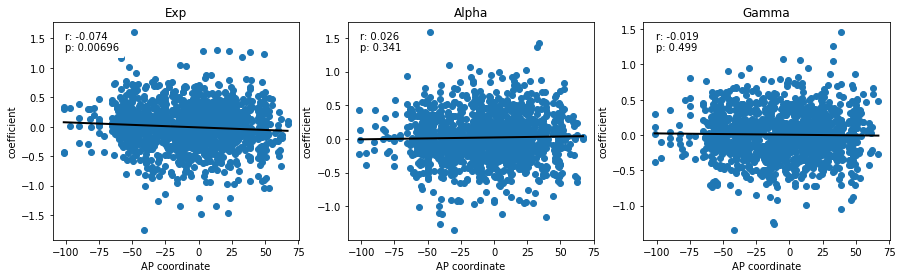

In [333]:
# compute correlation between coeeficient and position

# drop NaN
df_c = df.dropna()
x_data = df_c['pos_y']

# create fig
fig, axes = plt.subplots(1, 3, figsize=[15,4])

for ax, feature in zip(axes, ['exp', 'alpha', 'gamma']):
        # drop outliers (>5 STD) for plotting (keep for stats)
        y_data = df_c[f'{feature}_coef']
        outlier = np.abs(y_data) > (np.mean(y_data) + 5 * np.std(y_data))
        y_data_plt = y_data[~outlier]
        x_data_plt = x_data[~outlier]

        # plot data
        ax.set_title(feature[0].upper() + feature[1:])
        ax.scatter(x_data_plt, y_data_plt)#, c=y_data_plt, cmap='viridis')
        ax.set(xlabel=f"AP coordinate", ylabel="coefficient")

        # run regression and plot results
        stats = linregress(x_data, y_data)
        t_lin = np.linspace(np.nanmin(x_data), np.nanmax(x_data), 100)
        lin = stats.slope * t_lin + stats.intercept
        ax.plot(t_lin, lin, color='k', linewidth=2)
        ax.text(0.05, 0.87, f"r: {stats.rvalue:0.3f}\np: {stats.pvalue:0.3n}",
                transform=ax.transAxes, backgroundcolor='w')

plt.show()

Scores follow cognitive hierarchy, with more frontal channels better predicticting memory behavior

### Plot topography of regression results - PyVista

switch to pyvista environment

#### imports

In [6]:
# imports

# general
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# local
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from plots import plot_data_spatial
from settings import COLORS

In [2]:
# auto reload
%load_ext autoreload
%autoreload 2

#### load data

In [217]:
# load regression results from above
# results = pd.read_csv(fr"{PROJECT_PATH}\data\results\logistic_regression_scores_cv.csv", index_col=0)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\ordered_logit_scores.csv", index_col=0)

# load electrode locations
df_elec = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
df_elec.drop(columns=['index'], inplace=True)
df_elec.rename(columns={'chan_idx':'channel'}, inplace=True)

# merge channel info with regression results
df = pd.merge(results, df_elec, on=['patient', 'channel'])

df

patient material  channel  exp_coef  alpha_coef  gamma_coef  exp_pval  \
0      pat02    words        0  0.050752   -0.074132    0.534672  0.837750   
1      pat02    faces        0 -0.071749   -0.065502    0.112466  0.767859   
2      pat02    words        1  0.081823   -0.030260   -0.088118  0.707543   
3      pat02    faces        1 -0.108099   -0.006772   -0.155312  0.636531   
4      pat02    words        2 -0.147973    0.263788   -0.314793  0.496558   
...      ...      ...      ...       ...         ...         ...       ...   
1331   pat22    faces       50 -0.026995   -0.317926    0.226007  0.910590   
1332   pat22    words       51  0.169266   -0.246048    0.007386  0.408230   
1333   pat22    faces       51 -0.004801   -0.363537   -0.004340  0.983801   
1334   pat22    words       52 -0.396535    0.367376   -0.306553  0.167012   
1335   pat22    faces       52 -0.238231    0.113310   -0.433260  0.356107   

      alpha_pval  gamma_pval     score          label     pos_y     pos_x  \
0       0.766909    0.047462  0.500000        A01-A02 -65.43100  61.94490   
1       0.775485    0.682186  0.375000        A01-A02 -65.43100  61.94490   
2       0.901057    0.729153  0.411765        A02-A03 -70.93895  57.17765   
3       0.978103    0.545617  0.117647        A02-A03 -70.93895  57.17765   
4       0.248598    0.186945  0.578947        A03-A04 -75.39550  51.39440   
...          ...         ...       ...            ...       ...       ...   
1331    0.190147    0.333982  0.222222  MOF_07-MOF_08  44.50000 -14.00000   
1332    0.232860    0.971141  0.200000  MOF_08-MOF_09  48.00000 -14.00000   
1333    0.154586    0.983570  0.111111  MOF_08-MOF_09  48.00000 -14.00000   
1334    0.134433    0.234841  0.350000  MOF_09-MOF_10  52.00000 -14.00000   
1335    0.628283    0.094689  0.166667  MOF_09-MOF_10  52.00000 -14.00000   

         pos_z  
0      3.55955  
1      3.55955  
2     12.15540  
3     12.15540  
4     20.94335  
...        ...  
1331  16.50000  
1332  23.50000  
1333  23.50000  
1334  30.00000  
1335  30.00000  

[1336 rows x 14 columns]

### plot topography

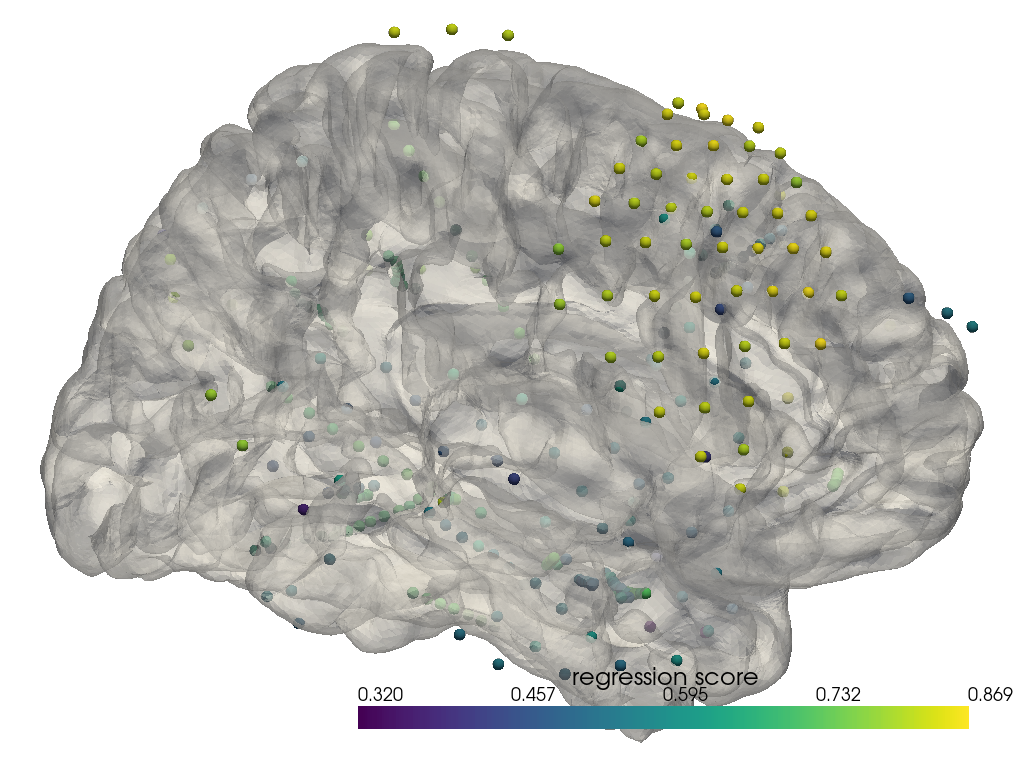

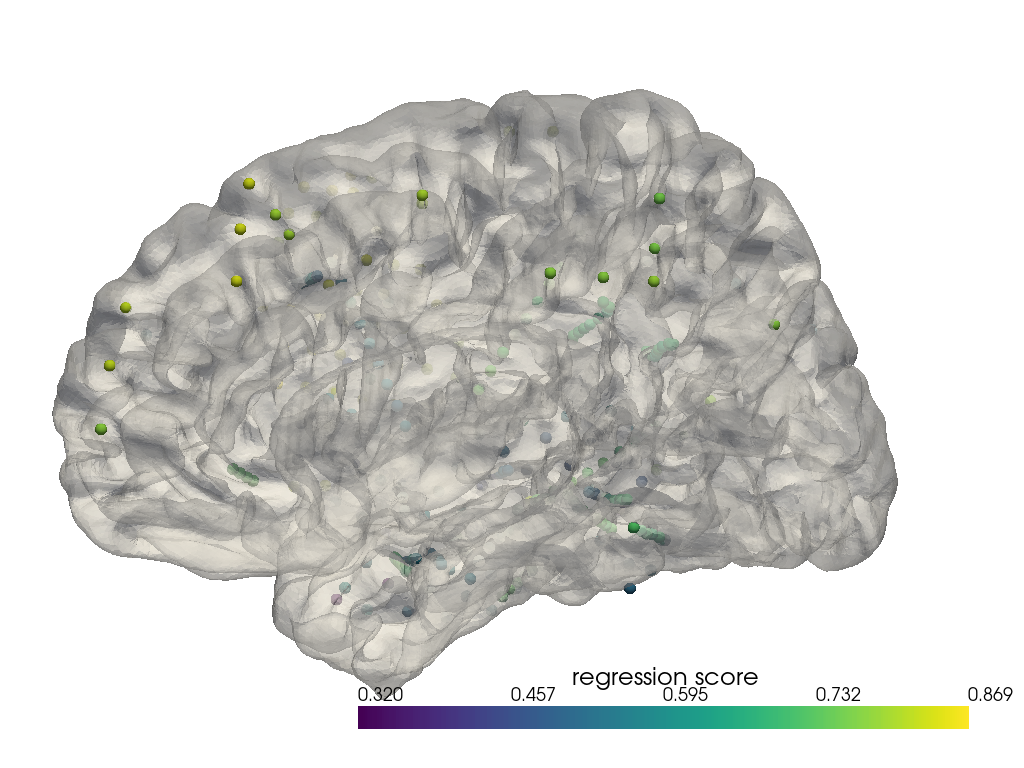

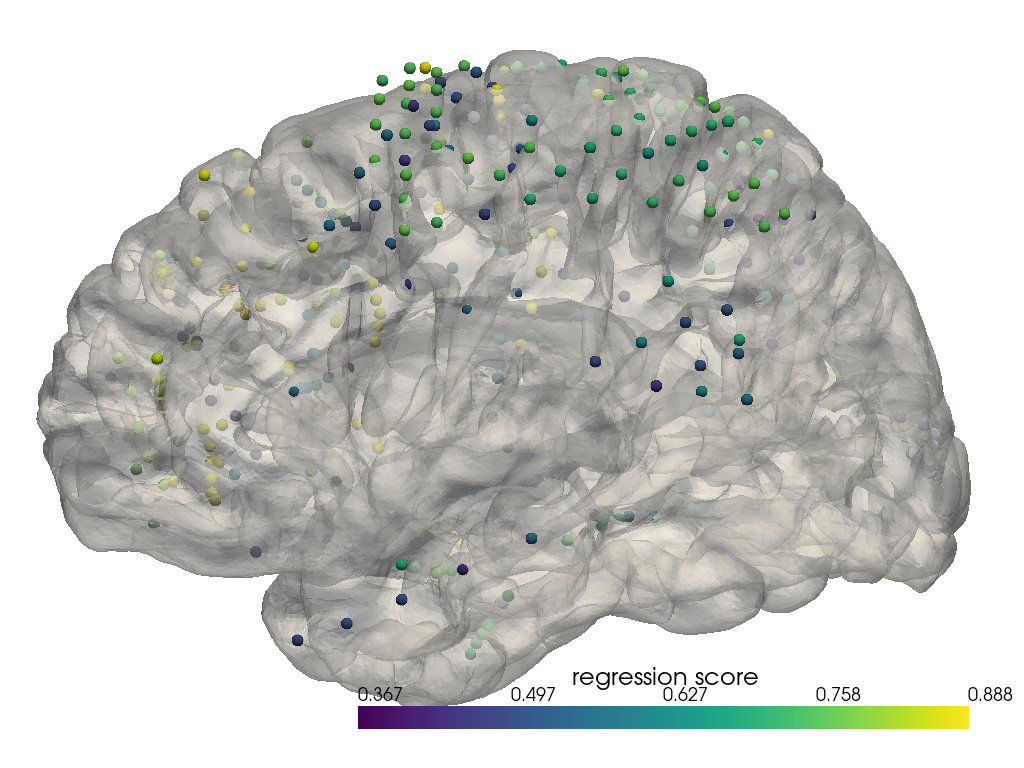

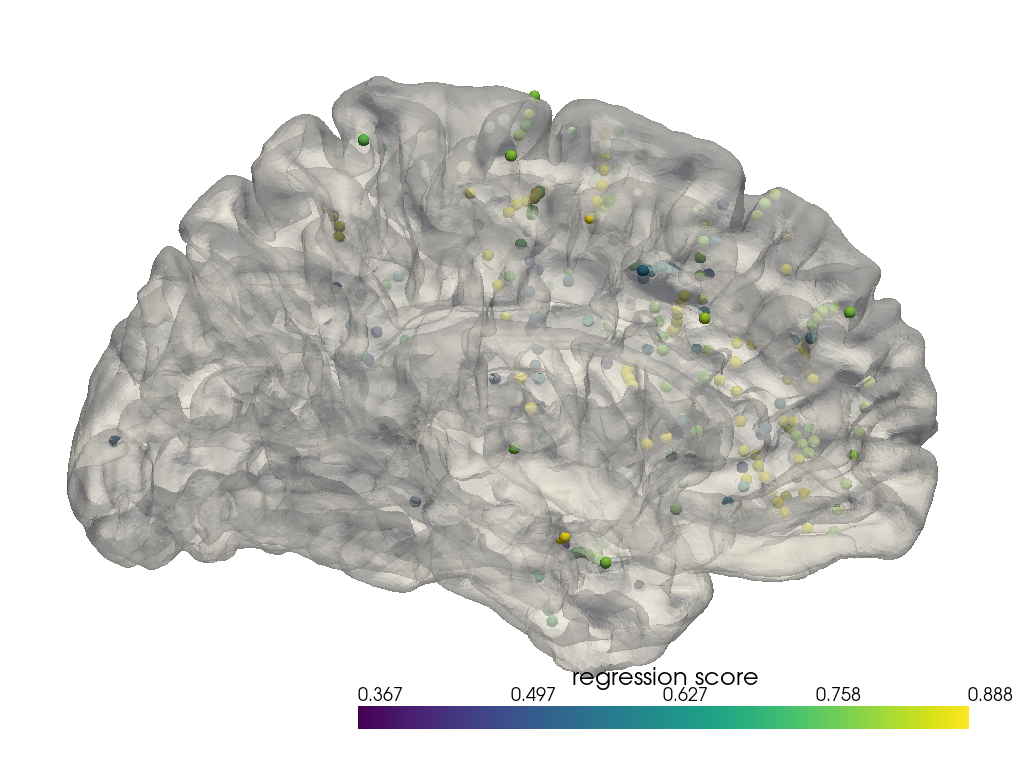

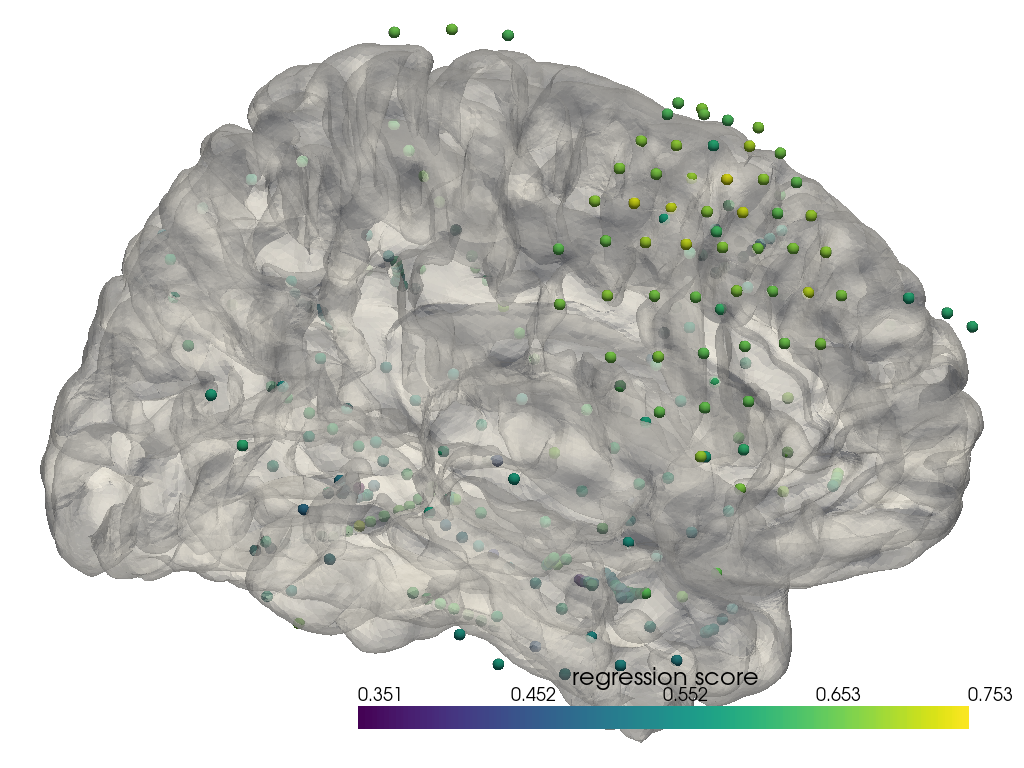

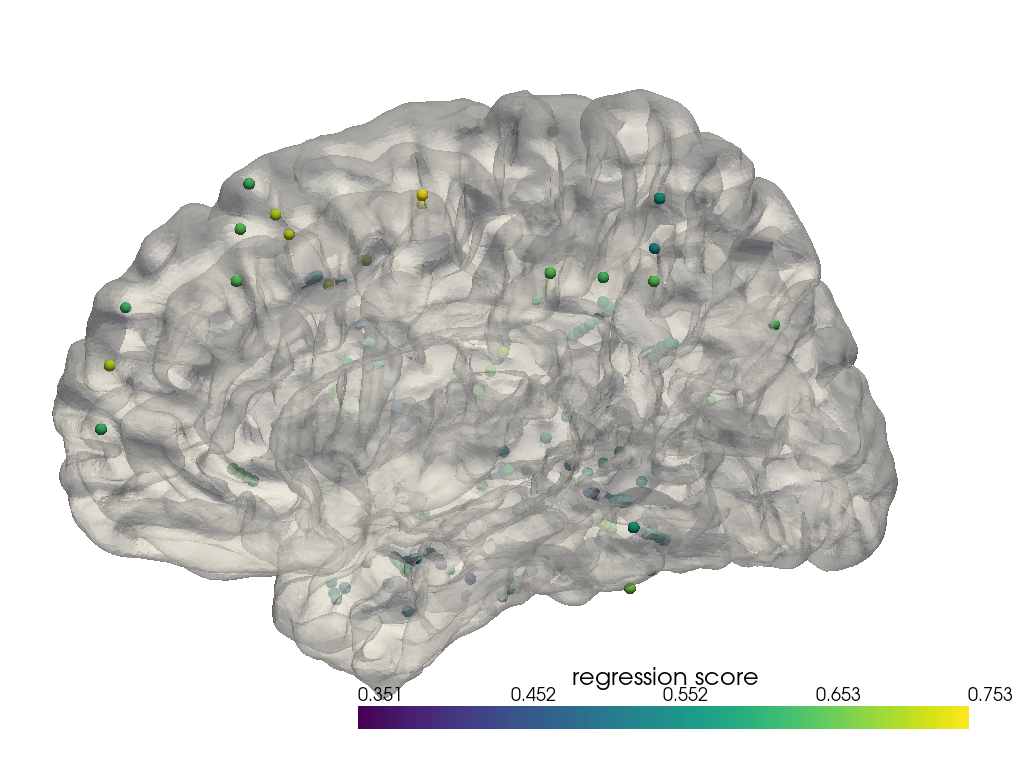

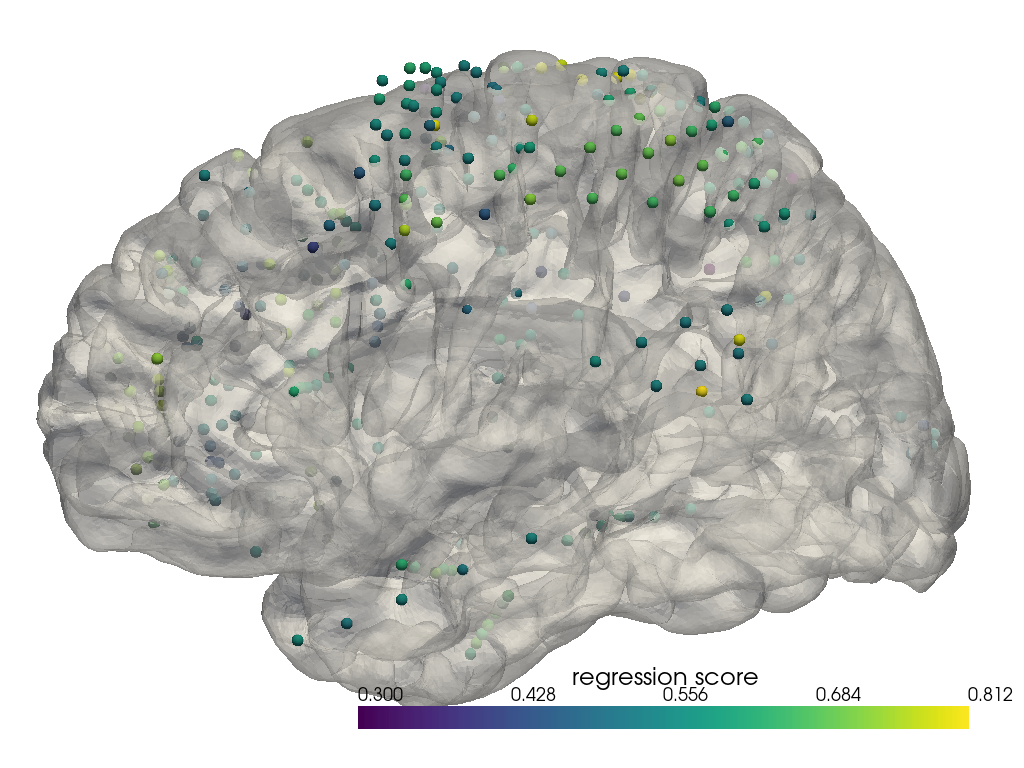

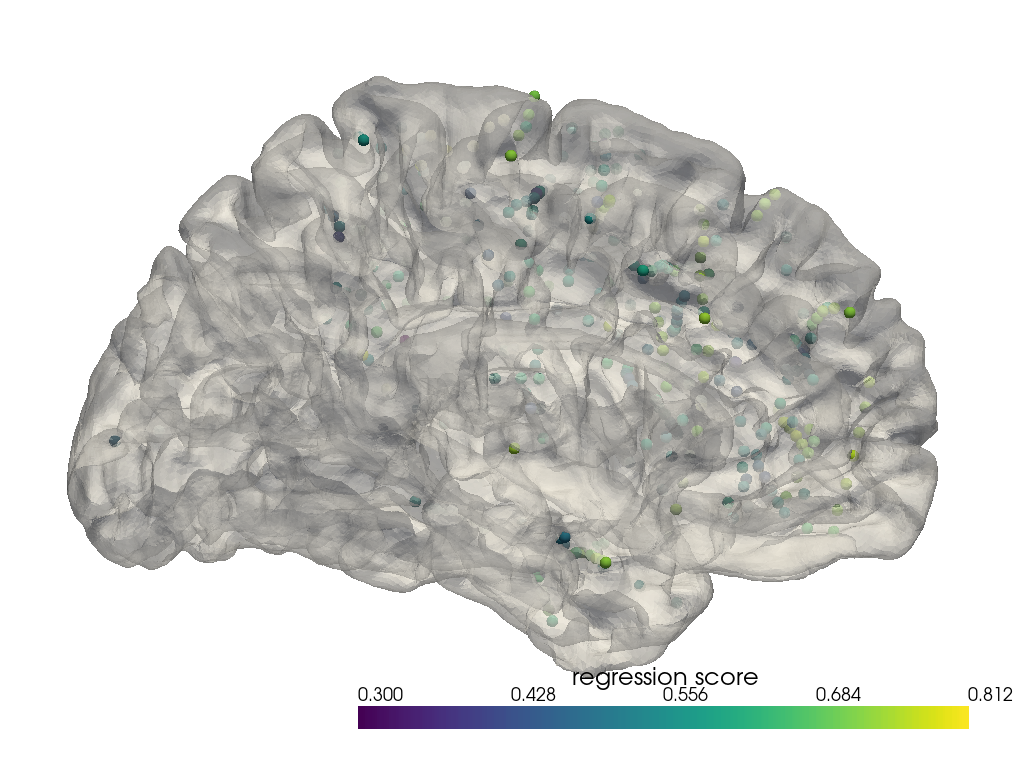

In [37]:
# plot topo map of scores

# loop through materials
for material in ['word', 'face']:

    # get info for trial block 
    df_i = df.loc[df['material']==material]
    df_i = df_i.dropna()
    elec_pos = df_i[['pos_x', 'pos_y', 'pos_z']]

    # split data by hemisphere
    pos = dict()
    score = dict()
    pos['right'] = elec_pos[elec_pos['pos_x'] >= 0].to_numpy()
    score['right'] = df_i.loc[df_i['pos_x'] >= 0, 'score'].to_numpy()
    pos['left'] = elec_pos[elec_pos['pos_x'] < 0].to_numpy()
    score['left'] = df_i.loc[df_i['pos_x'] < 0, 'score'].to_numpy()

    # plot ech hemisphere 
    for hemi in ['right', 'left']:
        for view in ['lateral', 'medial']:
            plot_data_spatial(score[hemi], pos[hemi], hemi, view,
                    cbar_label='regression score')

In [4]:
# prep data for plotting mean score across materials

# pivot score on material
index =['patient', 'channel', 'pos_x', 'pos_y', 'pos_z']
df_p = df.pivot(index=index, columns='material', values='score')

# compute mean score across materials
df_p['score'] = df_p.mean(axis=1)
df_p.reset_index(inplace=True)
df_p

material patient  channel     pos_x     pos_y     pos_z      face      word  \
0          pat02        0  61.94490 -65.43100   3.55955  0.611667  0.787500   
1          pat02        1  57.17765 -70.93895  12.15540  0.588971  0.793382   
2          pat02        2  51.39440 -75.39550  20.94335  0.628070  0.781053   
3          pat02        3  43.90980 -78.91950  30.13485  0.597076  0.795906   
4          pat02        4  35.21485 -80.96735  38.13475  0.595322  0.782456   
..           ...      ...       ...       ...       ...       ...       ...   
690        pat22       48 -14.00000  36.00000   3.00000  0.523529  0.531579   
691        pat22       49 -14.00000  40.50000   9.50000  0.604575  0.545789   
692        pat22       50 -14.00000  44.50000  16.50000  0.620261  0.524211   
693        pat22       51 -14.00000  48.00000  23.50000  0.570588  0.591579   
694        pat22       52 -14.00000  52.00000  30.00000  0.605229  0.560526   

material     score  
0         0.699583  
1         0.691176  
2         0.704561  
3         0.696491  
4         0.688889  
..             ...  
690       0.527554  
691       0.575182  
692       0.572236  
693       0.581084  
694       0.582878  

[695 rows x 8 columns]

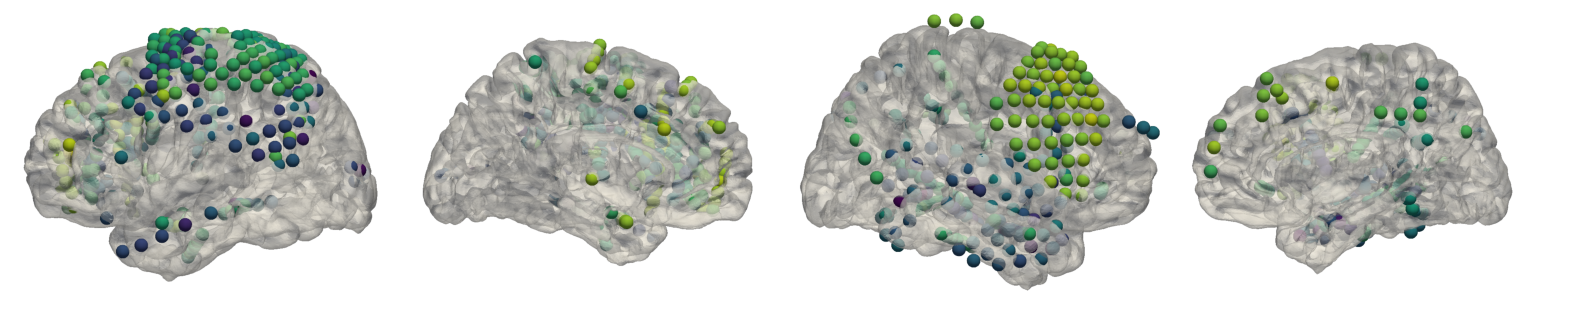

In [17]:
# plot mean score across materials

# set output path
path_out = f"{PROJECT_PATH}/figures/behavioral_modeling"
if not os.path.exists(f"{path_out}/temp"):
    os.makedirs(f"{path_out}/temp")

# get info for trial block 
df_i = df_p.dropna()
elec_pos = df_i[['pos_x', 'pos_y', 'pos_z']]

# split data by hemisphere
pos = dict()
score = dict()
pos['right'] = elec_pos[elec_pos['pos_x'] >= 0].to_numpy()
score['right'] = df_i.loc[df_i['pos_x'] >= 0, 'score'].to_numpy()
pos['left'] = elec_pos[elec_pos['pos_x'] < 0].to_numpy()
score['left'] = df_i.loc[df_i['pos_x'] < 0, 'score'].to_numpy()

# plot each hemisphere/view
clim = [np.min(df_p['score']), np.max(df_p['score'])]
for hemi in ['right', 'left']:
    for view in ['lateral', 'medial']:
        fname_out = f"{path_out}/temp/behavioral_modeling_{hemi}_{view}.png"
        plot_data_spatial(score[hemi], pos[hemi], hemi, view, plot_cbar=False,
                          fname_out=fname_out, elec_size=36, clim=clim)
        
# combine hemispheres and views into a single figure and save to file
images = [plt.imread(f"{path_out}/temp/{f}") for f in os.listdir(f"{path_out}/temp")]
image = np.concatenate(images, axis=1)
fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.imshow(image)
ax.axis('off')
fig.savefig(f"{path_out}/behavioral_modeling.png", bbox_inches='tight')

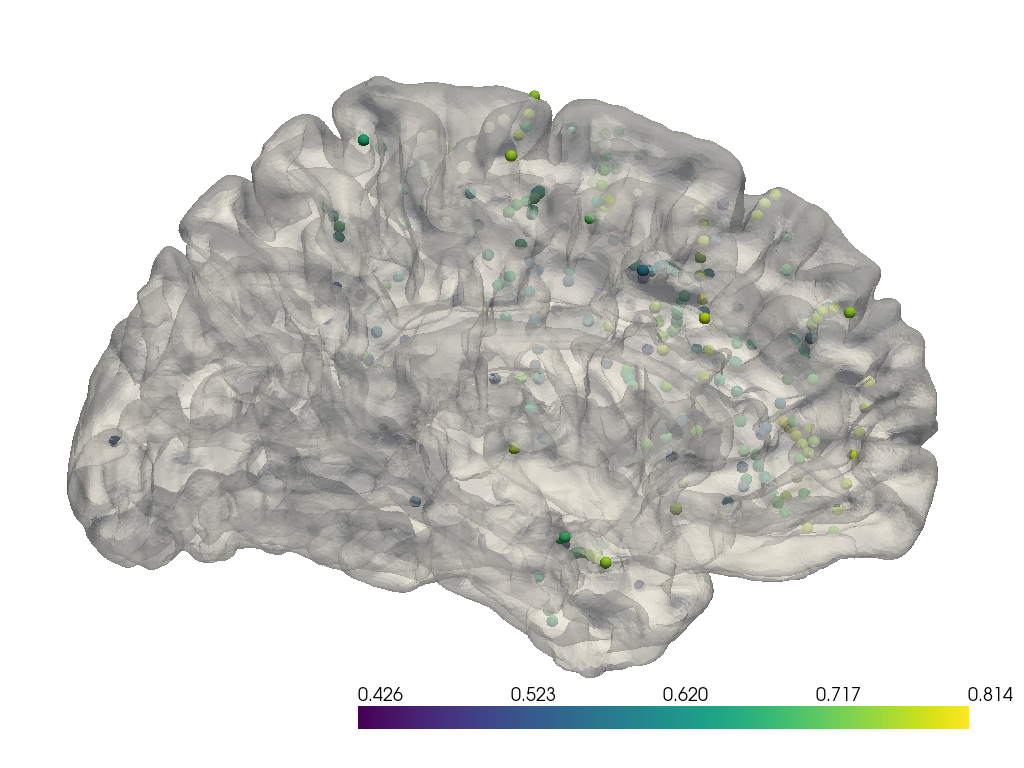

In [18]:
# plot an example of the plot above to screenshot the colorbar
plot_data_spatial(score[hemi], pos[hemi], hemi, view, clim=clim)